---
title: Transformer for timeseries
author: "Dien-Hoa Truong"
date: 2023-04-26
categories: [timeseries, deeplearning, transformer]

---

Developing an Intuition for Transformers and Applying Them to Time Series Classification

![Transformer Architecture](https://pytorch.org/tutorials/_images/transformer_architecture.jpg)

Struggling to learn a new deep learning architecture, such as Transformer, can be quite challenging. However, it doesn't have to be so daunting. In this blog post, I will demonstrate a practical approach to start using a new architecture, specifically the Transformer. We will construct a basic Transformer architecture and progressively fine-tune it to achieve the performance of the TST architecture (A Transformer-based Framework for Multivariate Time Series Representation Learning).

**Content:**

- Dataset to use: [FaceDetection](https://www.timeseriesclassification.com/description.php?Dataset=FaceDetection)
- Reference Model: [TST Model](https://timeseriesai.github.io/tsai/models.tst.html) implemented in tsai repository
- Baseline Model: LSTM Model 
- Our Simple TST Model
- Improvement

**References:**

- [tsai repository](https://github.com/timeseriesAI/tsai)
- [How to use Transformers with TimeSeries Tutorial](https://colab.research.google.com/github/timeseriesAI/tsai/blob/master/tutorial_nbs/07_Time_Series_Classification_with_Transformers.ipynb)


You'll need `fastai` and `tsai` to run the code in this blog-post

In [ ]:
!pip install -Uqq tsai

In [ ]:
import torch
from torch.utils.data import Dataset
from torch import nn
from fastai.data.core import DataLoader, DataLoaders
from fastai.learner import Learner
from fastai.losses import LabelSmoothingCrossEntropyFlat
from fastai.metrics import RocAucBinary, accuracy
from fastai.torch_core import Module
from fastai.layers import Flatten
from tsai.models.TST import TST
from tsai.models.RNN import LSTM
from tsai.data.external import get_UCR_data
from tsai.callback.core import ShowGraph as ShowGraphCallback2
from tsai.learner import plot_metrics
from tsai.imports import default_device
import numpy as np
from torch.nn.modules.transformer import TransformerEncoderLayer, TransformerEncoder


## Dataset: [FaceDetection](https://www.timeseriesclassification.com/description.php?Dataset=FaceDetection)

:::{.callout-note}

Why Time Series? Although the Transformer originates from the NLP domain and outperforms all previous architectures, I believe that, for those not yet familiar with NLP, it is more advantageous to start with a domain that requires less preprocessing, such as Time Series. This way, we can focus our attention on understanding the architecture itself.

:::


In this tutorial, we will be using a dataset from the well-known UEA & UCR Time Series repository. Although we won't delve into the details of this dataset in this blog post, it's worth mentioning its purpose. The objective is to classify whether a given MEG signal (Magnetoencephalography) represents a face or not. The input dimension is 144, and the sequence length is 62.

I chose this dataset because it contains a reasonable amount of data (5,890 training instances and 3,524 testing instances) and has been used in a [Transformer tutorial](https://colab.research.google.com/github/timeseriesAI/tsai/blob/master/tutorial_nbs/07_Time_Series_Classification_with_Transformers.ipynb) in the tsai repository. This ensures that we have a reliable reference model to aim to outperform.

We will utilize utility functions from the tsai and fastai libraries to facilitate our work and streamline the process.

In [ ]:
batch_size, c_in, c_out, seq_len = 64, 144, 2, 62
X, y, splits = get_UCR_data('FaceDetection', return_split=False)

X_train = X[splits[0]]
y_train = y[splits[0]]
X_valid = X[splits[1]]
y_valid = y[splits[1]]

mean_trn = np.mean(X_train, axis=(0,2), keepdims=True)
std_trn = np.std(X_train, axis=(0,2), keepdims=True)

In [ ]:
class TSDataset(Dataset):
    """TimeSeries DataSet for FaceDetection"""
    def __init__(self, X, y):
        super(TSDataset, self).__init__()
        self.X = torch.tensor(X)
        self.Y = torch.concat([torch.tensor([_y == '0'], dtype=int) for _y in y])
    
    def __len__(self): return len(self.X)
    
    def __getitem__(self, i):
        return self.X[i], self.Y[i]

The following code demonstrates how to create data loaders for the training and validation sets:

In [ ]:
dset_train = TSDataset(X_train, y_train)
dset_valid = TSDataset(X_valid, y_valid)

dl_train = DataLoader(dset_train, batch_size=batch_size, shuffle=True)
dl_valid = DataLoader(dset_valid, batch_size=batch_size, shuffle=False)

dls = DataLoaders(dl_train, dl_valid) 
dls = dls.cuda()

In [ ]:
x, y = next(iter(dl_train))

In [ ]:
x.shape, y.shape

(torch.Size([64, 144, 62]), torch.Size([64]))

## Reference Model

The reference model we will be using is the [TST](https://arxiv.org/abs/2010.02803) (Transformer-based Framework for Multivariate Time Series Representation Learning) and implemented by the tsai library.

In [ ]:
def evaluate_model(model, n_epoch=30):
    learn = Learner(dls, model, loss_func=LabelSmoothingCrossEntropyFlat(), 
                    metrics=[RocAucBinary(), accuracy],  cbs=ShowGraphCallback2())
    learn.fit_one_cycle(n_epoch, 1e-4) 

In [ ]:
model = TST(c_in, c_out, seq_len, dropout=0.3, fc_dropout=0.9, n_heads=1, n_layers=1)

epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.943482,0.710201,0.503936,0.505675,00:02
1,0.959244,0.705551,0.515424,0.515607,00:01
2,0.940436,0.697859,0.534342,0.532350,00:01
3,0.900420,0.692391,0.563204,0.543133,00:01
4,0.872391,0.682138,0.601740,0.567537,00:01
5,0.873357,0.674679,0.632084,0.591090,00:01
6,0.827063,0.668141,0.662991,0.618331,00:01
7,0.802059,0.658147,0.682879,0.635925,00:01
8,0.753277,0.653781,0.693962,0.641884,00:01
9,0.744286,0.647927,0.698235,0.643303,00:01


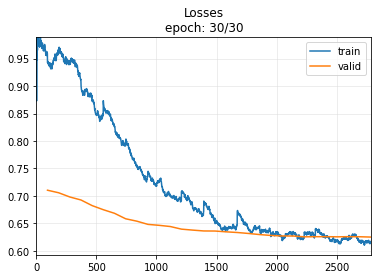

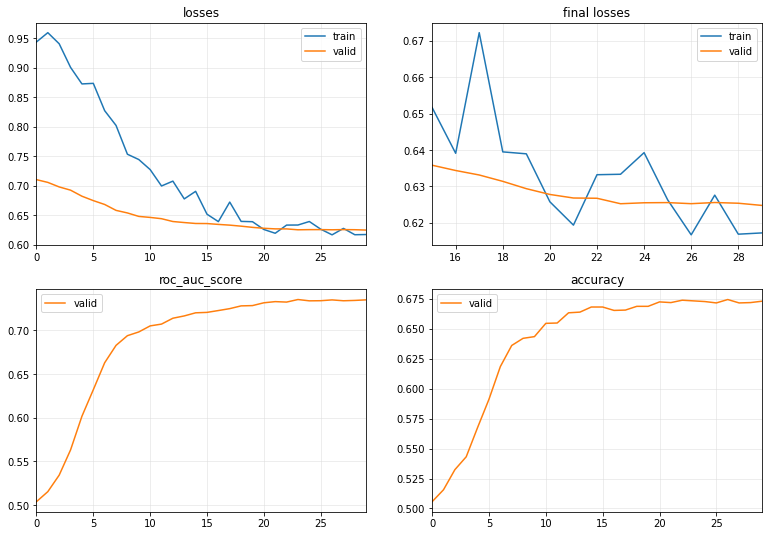

In [ ]:
evaluate_model(model)

:::{.callout-note}

For the simplicity for the reader, I do not use any normalization technique and training in lesser number of epochs than the [original reference notebook](https://colab.research.google.com/github/timeseriesAI/tsai/blob/master/tutorial_nbs/07_Time_Series_Classification_with_Transformers.ipynb). After 100 epochs, they reach an accuracy arount **0.70.1**

:::

## Baseline

We'll begin our journey by exploring an LSTM model, which was commonly used for sequence classification in the pre-transformer era.

:::{.callout-note}

Note: Observing the validation loss may lead you to believe that the model is overfitting. However, this is not the case, as the final metric (accuracy) continues to increase.

:::



In [ ]:
model = LSTM(144,2,rnn_dropout=0.3, fc_dropout=0.3)

epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.698941,0.696725,0.522427,0.517026,00:02
1,0.696502,0.695753,0.526428,0.516175,00:01
2,0.694726,0.694219,0.533478,0.519013,00:01
3,0.691055,0.692617,0.541788,0.529228,00:01
4,0.691306,0.691157,0.549403,0.538309,00:01
5,0.684514,0.689195,0.559889,0.545119,00:01
6,0.680696,0.686942,0.571706,0.545970,00:01
7,0.668403,0.685266,0.581042,0.554767,00:01
8,0.659610,0.685288,0.585615,0.558456,00:01
9,0.656271,0.686517,0.588135,0.557889,00:01


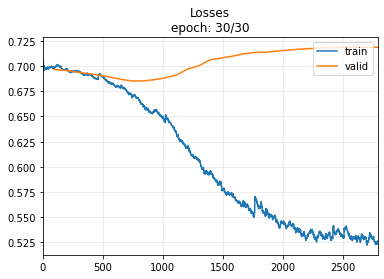

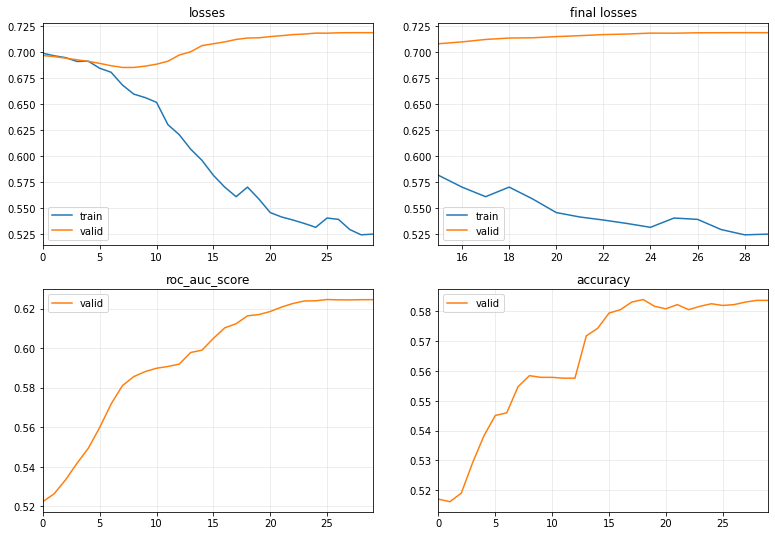

In [ ]:
evaluate_model(model)

## Our TST

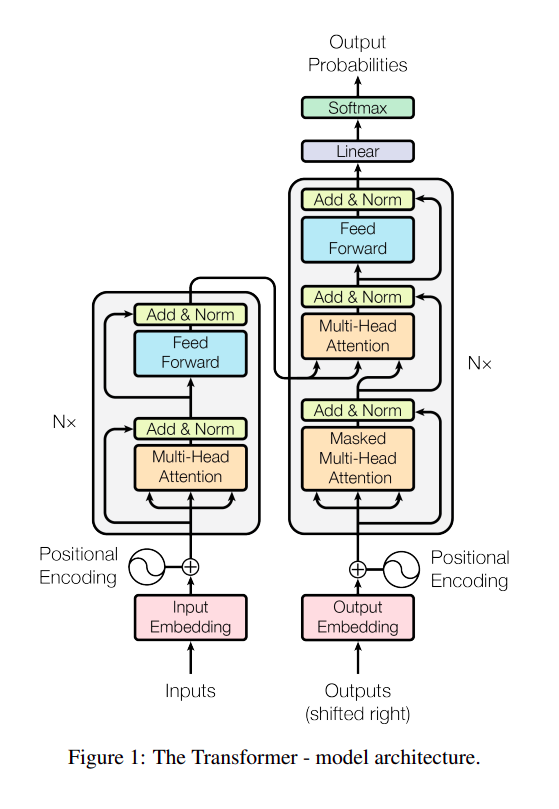

The diagram above illustrates the Transformer architecture as presented in the "Attention is All You Need" paper. The breakthrough in this architecture is the [Multi-Head Attention](https://pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html). The idea behind Attention is that if your model can focus on the most important parts of a long sequence, it can perform better without being affected by noise.

How does it work? Well, in my experience, when we are not very familiar with a new architecture, we shouldn't focus too much on understanding every detail of the architecture. I spent a lot of time reading various tutorials, trying to grasp the clever idea behind this, only to realize that I still didn't know how to apply it to a real case. I will attempt to cover building Self-Attention from scratch in a future blog post. However, in this one, we will start by learning how to use the Transformer module from PyTorch.

What do we need to pay attention to here? We will mainly focus on the **shapes** of the input and output. The input maintains its shape after passing through the Transformer Encoder. Subsequently, the output is flattened and passed through a linear layer, which generates the appropriate number of classes for the given classification task

Our first model as below is a very simple architecture with just one `TransformerEncoder` Layer and one `Linear` Layer

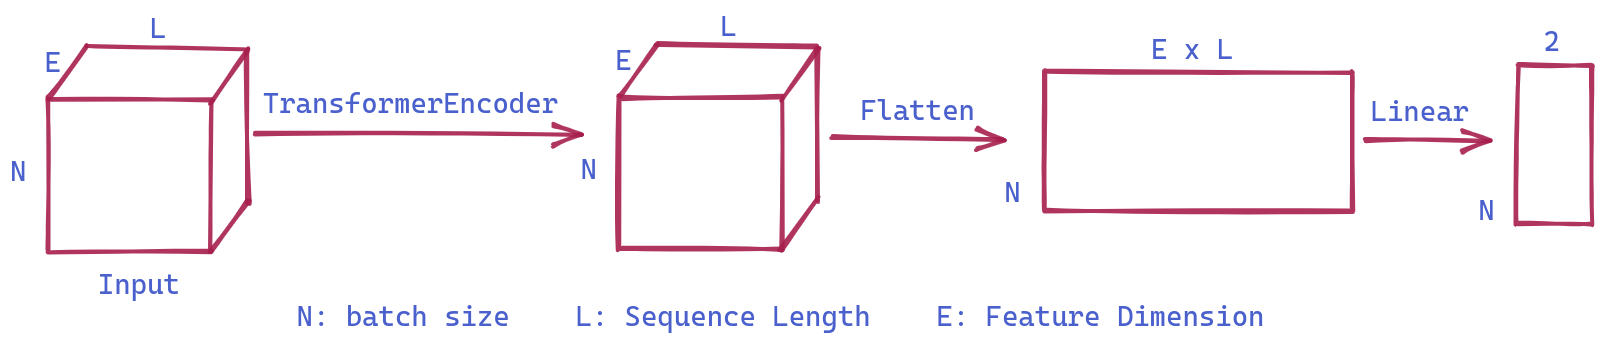

In [ ]:
batch_size, c_in, d_model, c_out, seq_len, dropout, fc_dropout  = 64, 144, 128, 2, 62, 0.7, 0.9

In [ ]:
class OurTST(Module):
    def __init__(self, c_in, c_out, seq_len, dropout):
        self.c_in, self.c_out, self.seq_len = c_in, c_out, seq_len
        encoder_layer = TransformerEncoderLayer(d_model=c_in, nhead=1, dropout=dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layer, num_layers=1)
        self.head = nn.Linear(seq_len*c_in, c_out)
    def forward(self, x):
        o = x.swapaxes(1,2) # [bs,c_in,seq_len] -> [bs,seq_len,c_in]
        o = self.transformer_encoder(o) # [bs,c_in,seq_len] -> [bs,c_in,seq_len]
        o = o.reshape(o.shape[0], -1) # [bs,c_in,seq_len] -> [bs,c_in x seq_len]
        o = self.head(o) # [bs,c_in x seq_len] -> [bs,]
        return o

In [ ]:
model = OurTST(c_in, c_out, seq_len, 0.9)

In [ ]:
model

OurTST(
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=144, out_features=144, bias=True)
        )
        (linear1): Linear(in_features=144, out_features=2048, bias=True)
        (dropout): Dropout(p=0.9, inplace=False)
        (linear2): Linear(in_features=2048, out_features=144, bias=True)
        (norm1): LayerNorm((144,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((144,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.9, inplace=False)
        (dropout2): Dropout(p=0.9, inplace=False)
      )
    )
  )
  (head): Linear(in_features=8928, out_features=2, bias=True)
)

epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.771023,0.765103,0.501380,0.503405,00:01
1,0.767232,0.743445,0.526820,0.517877,00:01
2,0.760522,0.713145,0.577938,0.552781,00:01
3,0.718567,0.686044,0.636998,0.599603,00:01
4,0.707388,0.671847,0.679890,0.627128,00:01
5,0.667916,0.675715,0.702388,0.650114,00:01
6,0.646124,0.692107,0.713854,0.657492,00:01
7,0.626370,0.714405,0.720573,0.665153,00:01
8,0.623622,0.739222,0.721124,0.671396,00:01
9,0.597921,0.755921,0.722508,0.669410,00:01


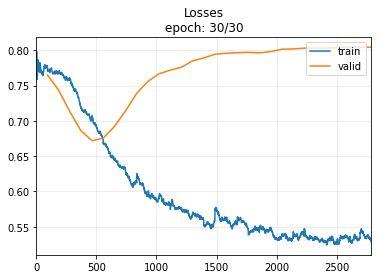

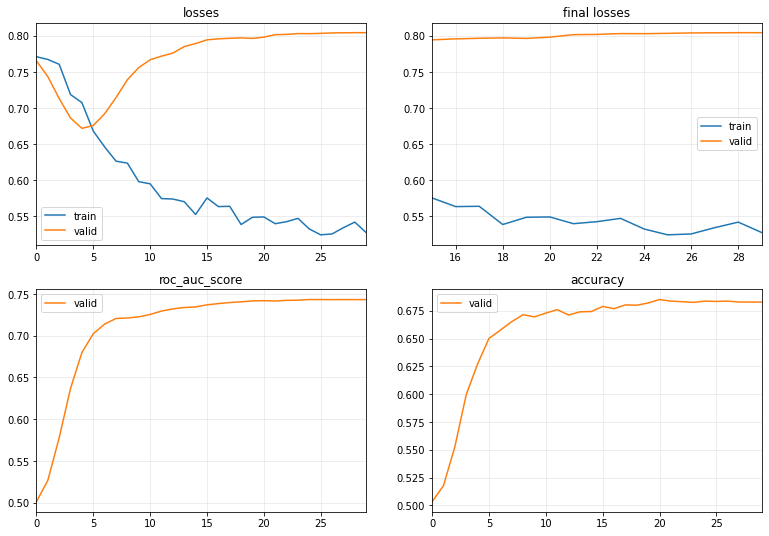

In [ ]:
evaluate_model(model, 30)

Well, our model outperforms the LSTM model and even better than the TST model after 30 epochs

## Upgrades

In this section, I will discuss how we can build upon our basic Transformer architecture to achieve even greater results. We will explore several ideas inspired by the original paper and general deep learning concepts.

**1- Feature Standardizing:** 

To enhance neural network training, it is recommended that input data have a zero mean and unit standard deviation  ( for more details, refer to this [lesson](https://course.fast.ai/Lessons/lesson17.html) from fast.ai). In line with the original paper, we employ feature standardization, which standardizes each feature separately.
```python
mean_trn = np.mean(X_train, axis=(0,2), keepdims=True)
std_trn = np.std(X_train, axis=(0,2), keepdims=True)
... # In the Dataset
self.X = (self.X - mean_trn)/std_trn
```
    
**2- Input Projection**

Before feeding the input into the `TransformerEncoder` layer, it can be projected into another dimension, allowing us to control the input received by the `TransformerEncoder`. In general, using suitable techniques, a deeper network can potentially outperform a shallow one.

```python
    def __init__( ... )
        self.W_P = nn.Linear(c_in, d_model)
    def forward(self, x):
        o = x.swapaxes(1, 2)  
        o = self.W_P(o)  # Input Projection
        
```

**3- Positional Encoding**


Transformers do not inherently capture the positional order of input data, which can be crucial for certain tasks. To embed this information, we can employ techniques such as passing the input through a specific function (e.g., a `sinusoidal` function) or creating learnable parameters for position (as implemented in our code).

```python
    def __init__( ... )
        # Positional encoding
        W_pos = torch.empty((seq_len, d_model), device=default_device())
        nn.init.uniform_(W_pos, -0.02, 0.02)
        self.W_pos = nn.Parameter(W_pos, requires_grad=True)
    def forward(self, x):
        o = x.swapaxes(1, 2)  
        o = self.W_P(o)  
        o = o + self.W_pos # Positional Encoding

```

**4- DropOut**

Deep neural networks can be prone to overfitting. To mitigate this issue, we can introduce dropout layers in our model, making it more resistant to overfitting. In our architecture, there are two types of dropout: one within the `TransformerEncoder` layer and another just before the final `Linear` layer.

```python
    def __init__( ... )
        # Transformer encoder layers
        encoder_layer = TransformerEncoderLayer(d_model=d_model, nhead=1, dropout=drop_out) # dropout inside Transformer Layer
        self.transformer_encoder = TransformerEncoder(encoder_layer, num_layers=n_layers)

        self.head = nn.Sequential(
            nn.GELU(),
            Flatten(),
            nn.Dropout(fc_dropout), # fully connected dropout
            nn.Linear(seq_len * d_model, c_out)
        )
```

In [ ]:
batch_size, c_in, d_model, c_out, seq_len,fc_dropout = 64, 144, 128, 2, 62, 0.9
X, y, splits = get_UCR_data('FaceDetection', return_split=False)

X_train = X[splits[0]]
y_train = y[splits[0]]
X_valid = X[splits[1]]
y_valid = y[splits[1]]

mean_trn = np.mean(X_train, axis=(0,2), keepdims=True)
std_trn = np.std(X_train, axis=(0,2), keepdims=True)

In [ ]:
class TSDataset(Dataset):
    """TimeSeries DataSet for FaceDetection"""
    def __init__(self, X, y):
        super(TSDataset, self).__init__()
        self.X = torch.tensor(X)
        self.X = (self.X - mean_trn)/std_trn
        self.Y = torch.concat([torch.tensor([_y == '0'], dtype=int) for _y in y])
    
    def __len__(self): return len(self.X)
    
    def __getitem__(self, i):
        return self.X[i], self.Y[i]

In [ ]:
class OurTST(Module):
    def __init__(self, c_in, c_out, d_model, seq_len, n_layers, drop_out, fc_dropout):
        self.c_in, self.c_out, self.seq_len = c_in, c_out, seq_len
        self.W_P = nn.Linear(c_in, d_model)

        # Positional encoding
        W_pos = torch.empty((seq_len, d_model), device=default_device())
        nn.init.uniform_(W_pos, -0.02, 0.02)
        self.W_pos = nn.Parameter(W_pos, requires_grad=True)

        # Transformer encoder layers
        encoder_layer = TransformerEncoderLayer(d_model=d_model, nhead=1, dropout=drop_out)
        self.transformer_encoder = TransformerEncoder(encoder_layer, num_layers=n_layers)

        self.head = nn.Sequential(
            nn.GELU(),
            Flatten(),
            nn.Dropout(fc_dropout),
            nn.Linear(seq_len * d_model, c_out)
        )

    def forward(self, x):
        o = x.swapaxes(1, 2)  # [bs,c_in,seq_len] -> [bs,seq_len,c_in]
        o = self.W_P(o)  # [bs,seq_len,c_in] -> [bs,seq_len,d_model]
        o = o + self.W_pos
        o = self.transformer_encoder(o)  # [bs, seq_len, d_model] -> [bs, seq_len, d_model]
        o = o.contiguous()
        o = self.head(o)  # [bs,seq_len x d_model] -> [bs,c_out]
        return o


In [ ]:
model = OurTST(c_in, c_out, d_model, seq_len, 3, 0.4 ,0.9)

epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.925684,0.714104,0.499395,0.500000,00:02
1,0.941063,0.708397,0.513332,0.510499,00:02
2,0.910563,0.697380,0.547459,0.532066,00:02
3,0.875563,0.684338,0.586375,0.553916,00:02
4,0.788294,0.675705,0.634576,0.583144,00:02
5,0.729792,0.669882,0.668022,0.613224,00:02
6,0.698079,0.661823,0.690192,0.640182,00:02
7,0.678686,0.650137,0.703406,0.646141,00:02
8,0.669151,0.639466,0.713121,0.653235,00:02
9,0.640111,0.631399,0.720097,0.656924,00:02


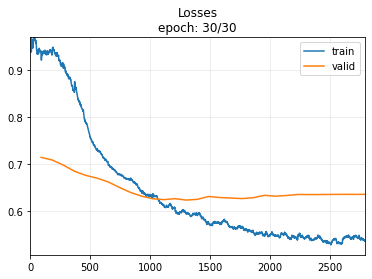

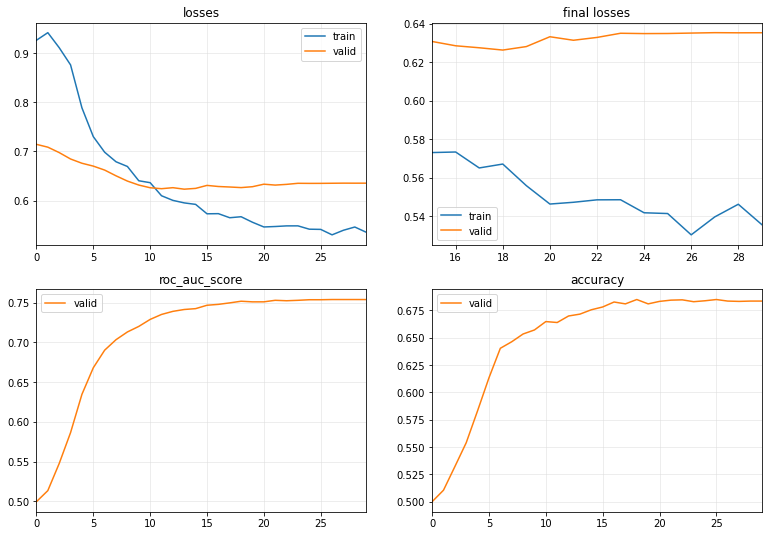

In [ ]:
evaluate_model(model, n_epoch=30)

Let's try training with more epochs. In the following example, we will train for 100 epochs, which is the same as in this [tutorial](https://colab.research.google.com/github/timeseriesAI/tsai/blob/master/tutorial_nbs/07_Time_Series_Classification_with_Transformers.ipynb) from `tsai` 

epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.986113,0.723611,0.495537,0.501986,00:02
1,0.985938,0.715433,0.500191,0.498581,00:02
2,0.959804,0.714567,0.505571,0.503121,00:02
3,0.935837,0.711624,0.512527,0.509081,00:02
4,0.949967,0.708520,0.520180,0.511351,00:02
5,0.938500,0.703618,0.531381,0.521283,00:02
6,0.914983,0.698704,0.546194,0.528944,00:02
7,0.916452,0.693311,0.562272,0.545687,00:02
8,0.863562,0.688229,0.581601,0.557605,00:02
9,0.825720,0.684290,0.603750,0.570658,00:02


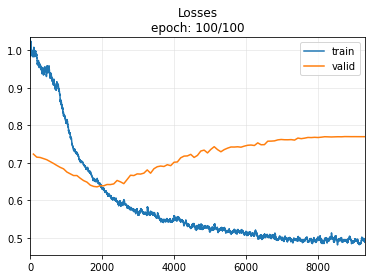

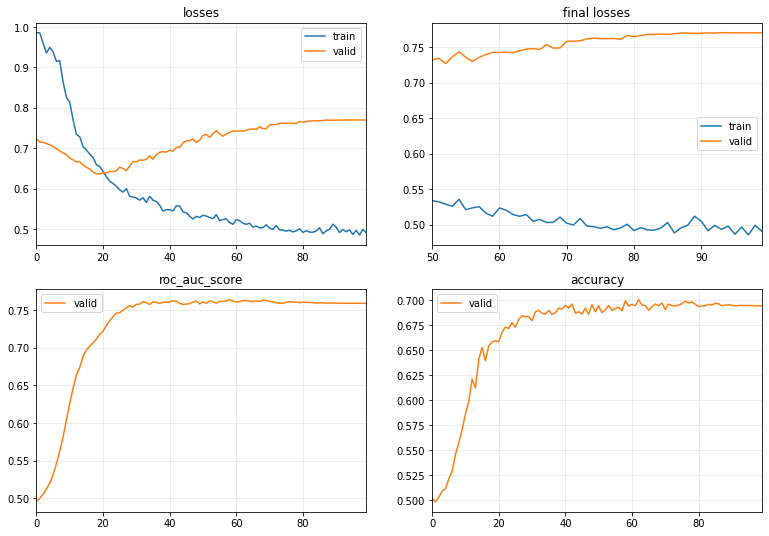

In [ ]:
model = OurTST(c_in, c_out, d_model, seq_len, 3, 0.6 ,0.9)
evaluate_model(model, n_epoch=100)

:::{.callout-note}

There may be differences between the implementation of the Transformer in pytorch and tsai (for example, `pytorch` uses `LayerNorm` in the `TransformerEncoder` layer, which is popular in NLP, while `tsai` employs `BatchNorm`)

:::